In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [05:46:47] Enabling RDKit 2019.09.3 jupyter extensions
[05:46:47] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

number of all smiles:  41127


number of successfully processed smiles:  41127


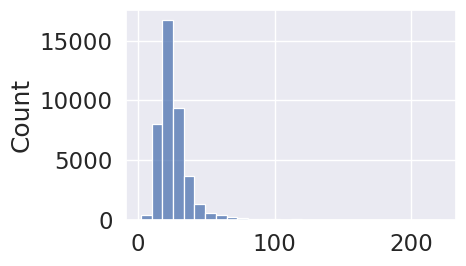

In [4]:
task_name = 'HIV'
tasks = ['HIV_active']
raw_filename = "../data/HIV.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
        remained_smiles.append(smiles)
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
random_seed = 8
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 200
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 4
T = 2
weight_decay = 3.9 # also known as l2_regularization_lambda
learning_rate = 3
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,smiles,activity,HIV_active,cano_smiles
71,C1CN[Co-4]23(N1)(NCCN2)NCCN3,CI,0,C1CN[Co-4]23(N1)(NCCN2)NCCN3
79,O=C1O[Cu-5]2(O)(O)(OC1=O)OC(=O)C(=O)O2,CI,0,O=C1O[Cu-5]2(O)(O)(OC1=O)OC(=O)C(=O)O2
88,CCc1cc[n+]([Mn](SC#N)(SC#N)([n+]2ccc(CC)cc2)([...,CI,0,CCc1cc[n+]([Mn](SC#N)(SC#N)([n+]2ccc(CC)cc2)([...
137,O=C1O[Al]23(OC1=O)(OC(=O)C(=O)O2)OC(=O)C(=O)O3,CI,0,O=C1O[Al]23(OC1=O)(OC(=O)C(=O)O2)OC(=O)C(=O)O3
138,O=C1C[N+]23CC[N+]45CC(=O)O[Ni-4]24(O1)(OC(=O)C...,CI,0,O=C1C[N+]23CC[N+]45CC(=O)O[Ni-4]24(O1)(OC(=O)C...
...,...,...,...,...
40746,CC1OC(OC2C(O)COC(OC3C(C)OC(OC4C(OC(=O)C56CCC(C...,CM,1,CC1OC(OC2C(O)COC(OC3C(C)OC(OC4C(OC(=O)C56CCC(C...
40975,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,CI,0,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...
41000,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,CI,0,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...
41027,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...,CI,0,CC(C)CCCC(C)C1CCC2C3CCC4CC(CCC=C(c5cc(Cl)c(OCc...


In [7]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

808057
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
GRUCell.3.weight_ih torch.Size([450, 150])
GRUCell.3.weight_hh torch.Size([450, 150])
GRUCell.3.bias_ih torch.Size([450])
GRUCell.3.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
align.3.weight torch.S

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall, 


In [10]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.80:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >16) and (epoch - best_param["loss_epoch"] >18):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.6393898617665909]
valid_roc:[0.6124912330859984]



EPOCH:	1
train_roc:[0.7148947011787287]
valid_roc:[0.7178036479296682]



EPOCH:	2
train_roc:[0.7371616707319313]
valid_roc:[0.736385038395733]



EPOCH:	3
train_roc:[0.7499073292561809]
valid_roc:[0.7332490518331226]



EPOCH:	4
train_roc:[0.7631798196081568]
valid_roc:[0.731310279513788]



EPOCH:	5
train_roc:[0.7668495810633955]
valid_roc:[0.7380513104582026]



EPOCH:	6
train_roc:[0.7729019937988952]
valid_roc:[0.7524402174641394]



EPOCH:	7
train_roc:[0.7827148934583642]
valid_roc:[0.75687169705119]



EPOCH:	8
train_roc:[0.7894382504844275]
valid_roc:[0.7688371386579584]



EPOCH:	9
train_roc:[0.7977018736241233]
valid_roc:[0.7717207274416692]



EPOCH:	10
train_roc:[0.7929288304898096]
valid_roc:[0.7680017690180609]



EPOCH:	11
train_roc:[0.8008771704676982]
valid_roc:[0.7630118872653036]



EPOCH:	12
train_roc:[0.8023671971503881]
valid_roc:[0.7759869199876703]



EPOCH:	13
train_roc:[0.8016410016437574]
valid_roc:[0.7663667674768709]



EPOCH:	14
train_roc:[0.8158153431411223]
valid_roc:[0.7861967451854566]



EPOCH:	15
train_roc:[0.81797728675192]
valid_roc:[0.7853948796755014]



EPOCH:	16
train_roc:[0.8188241703671923]
valid_roc:[0.7949792944476956]



EPOCH:	17
train_roc:[0.8159009217361797]
valid_roc:[0.7889574854927116]



EPOCH:	18
train_roc:[0.8226397058744065]
valid_roc:[0.7958034960442791]



EPOCH:	19
train_roc:[0.8237854864106323]
valid_roc:[0.7928618334353347]



EPOCH:	20
train_roc:[0.8285879788483757]
valid_roc:[0.7930784934756291]



EPOCH:	21
train_roc:[0.8168572676017677]
valid_roc:[0.7830361889275551]



EPOCH:	22
train_roc:[0.830101754097776]
valid_roc:[0.7874542668626285]



EPOCH:	23
train_roc:[0.8414273482982626]
valid_roc:[0.8051757179935046]



EPOCH:	24
train_roc:[0.8423813706408276]
valid_roc:[0.8126985119699088]



EPOCH:	25
train_roc:[0.84436532158099]
valid_roc:[0.8094687138434598]



EPOCH:	26
train_roc:[0.848078041194442]
valid_roc:[0.8145859112899984]



EPOCH:	27
train_roc:[0.8469194002284618]
valid_roc:[0.807829245084944]



EPOCH:	28
train_roc:[0.8526578131433593]
valid_roc:[0.8063081575855584]



EPOCH:	29
train_roc:[0.8538958456489059]
valid_roc:[0.8172282703381237]



EPOCH:	30
train_roc:[0.8553441434791677]
valid_roc:[0.8036345280161534]



EPOCH:	31
train_roc:[0.8617303059809642]
valid_roc:[0.811865375938674]



EPOCH:	32
train_roc:[0.8676670423929478]
valid_roc:[0.8124528150169977]



EPOCH:	33
train_roc:[0.8638418885811271]
valid_roc:[0.8191648090487955]



EPOCH:	34
train_roc:[0.8623908484533442]
valid_roc:[0.8080727084291924]



EPOCH:	35
train_roc:[0.8698930044665677]
valid_roc:[0.8149790264146559]



EPOCH:	36
train_roc:[0.8682772103458374]
valid_roc:[0.8214810612321478]



EPOCH:	37
train_roc:[0.8691686731818973]
valid_roc:[0.8080369706905873]



EPOCH:	38
train_roc:[0.8767809939058855]
valid_roc:[0.8224884187390833]



EPOCH:	39
train_roc:[0.8760968244464882]
valid_roc:[0.8195735594340929]



EPOCH:	40
train_roc:[0.8557320637531489]
valid_roc:[0.8140498452109197]



EPOCH:	41
train_roc:[0.8751157979032097]
valid_roc:[0.8319097800788909]



EPOCH:	42
train_roc:[0.8789774391318022]
valid_roc:[0.8178469799377268]



EPOCH:	43
train_roc:[0.8857109683255179]
valid_roc:[0.8114677935966907]



EPOCH:	44
train_roc:[0.8901070063405162]
valid_roc:[0.82130907336511]



EPOCH:	45
train_roc:[0.8857910893432427]
valid_roc:[0.8086244097689107]



EPOCH:	46
train_roc:[0.8897906829968909]
valid_roc:[0.8275922145336447]



EPOCH:	47
train_roc:[0.8934494482443351]
valid_roc:[0.8131452337024744]



EPOCH:	48
train_roc:[0.890382870664063]
valid_roc:[0.8013607143973946]



EPOCH:	49
train_roc:[0.8948818056259515]
valid_roc:[0.8225710622596079]



EPOCH:	50
train_roc:[0.8963050715482984]
valid_roc:[0.8198482932996207]



EPOCH:	51
train_roc:[0.9033099936346276]
valid_roc:[0.8061004319799153]



EPOCH:	52
train_roc:[0.9052353026361719]
valid_roc:[0.8119725891544898]



EPOCH:	53
train_roc:[0.9060445100554512]
valid_roc:[0.8196215820203439]



EPOCH:	54
train_roc:[0.9063482836729819]
valid_roc:[0.8022675595145027]



EPOCH:	55
train_roc:[0.9120506414544605]
valid_roc:[0.8338306835289231]



EPOCH:	56
train_roc:[0.9094533209628247]
valid_roc:[0.8208623516325445]



EPOCH:	57
train_roc:[0.9120850755253053]
valid_roc:[0.8170317127757948]



EPOCH:	58
train_roc:[0.9117466516952532]
valid_roc:[0.8299039994996716]



EPOCH:	59
train_roc:[0.9191140433731503]
valid_roc:[0.8298950650650204]



EPOCH:	60
train_roc:[0.9203216944642874]
valid_roc:[0.8118787775906511]



EPOCH:	61
train_roc:[0.9235765314448315]
valid_roc:[0.8088097992879256]



EPOCH:	62
train_roc:[0.9070551750261262]
valid_roc:[0.8261448361201323]



EPOCH:	63
train_roc:[0.9200176506696609]
valid_roc:[0.8207506711994033]



EPOCH:	64
train_roc:[0.9238591772134798]
valid_roc:[0.8237079690689872]



EPOCH:	65
train_roc:[0.9272534931196701]
valid_roc:[0.8171344587742849]



EPOCH:	66
train_roc:[0.9357345412771163]
valid_roc:[0.8300380160194414]



EPOCH:	67
train_roc:[0.9263094943473548]
valid_roc:[0.8240117398471318]



EPOCH:	68
train_roc:[0.936206229959614]
valid_roc:[0.828318137349064]



EPOCH:	69
train_roc:[0.9354664175273607]
valid_roc:[0.8211125158027813]



EPOCH:	70
train_roc:[0.932978356653219]
valid_roc:[0.8149611575453534]



EPOCH:	71
train_roc:[0.9322319248821217]
valid_roc:[0.8100695545737604]



EPOCH:	72
train_roc:[0.9324847971348259]
valid_roc:[0.8330667893662358]



In [11]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features,num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:55
test_roc:[0.8232458987838864]
test_roc_mean: 0.8232458987838864
